# 1. Data Understanding and Exploration

## Project Overview
The goal of this project is to analyze the Wine Quality dataset, which contains physicochemical attributes of red and white variants of Portuguese "Vinho Verde" wine. The target variable `quality` represents the wine’s sensory quality score rated between 0 and 10.

### Dataset Source
The dataset was obtained from the UCI Machine Learning Repository:
[https://archive.ics.uci.edu/dataset/186/wine+quality](https://archive.ics.uci.edu/dataset/186/wine+quality)

### Author
Group 32?

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# plotting defaults
%matplotlib inline
plt.style.use('default')
np.random.seed(42)
sns.set(style="whitegrid", palette="deep", font_scale=1.1)

### Load Data

In [53]:
red = pd.read_csv('winequality-red.csv', sep=';')
white = pd.read_csv('winequality-white.csv', sep=';')

red['color'] = 'red'
white['color'] = 'white'
df = pd.concat([red, white], ignore_index=True)

df.head()
df.shape

(6497, 13)

Note number of rows and columns, confirm the dataset meets the >1000 instances & >=10 features requirement.

### Quick statistics

In [54]:
print("\n--- Dataset Info ---")
print(df.info())

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Summary Statistics ---")
display(df.describe())



--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB
None

--- Missing Values ---
fixed acidit

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### Clean Dataset - Added Missing Values and Outliers

In [55]:
np.random.seed(42)

# Missing values randomly in a few numeric columns
for col in ['residual sugar', 'chlorides', 'sulphates']:
    missing_indices = df.sample(frac=0.01).index
    df.loc[missing_indices, col] = np.nan

# Outliers
outlier_indices = df.sample(frac=0.005).index
df.loc[outlier_indices, 'alcohol'] *= 3
df.loc[outlier_indices, 'density'] *= 2
print(f"Missing values per column:\n{df.isnull().sum()}")

Missing values per column:
fixed acidity            0
volatile acidity         0
citric acid              0
residual sugar          65
chlorides               65
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       0
sulphates               65
alcohol                  0
quality                  0
color                    0
dtype: int64


### Univariate Analysis

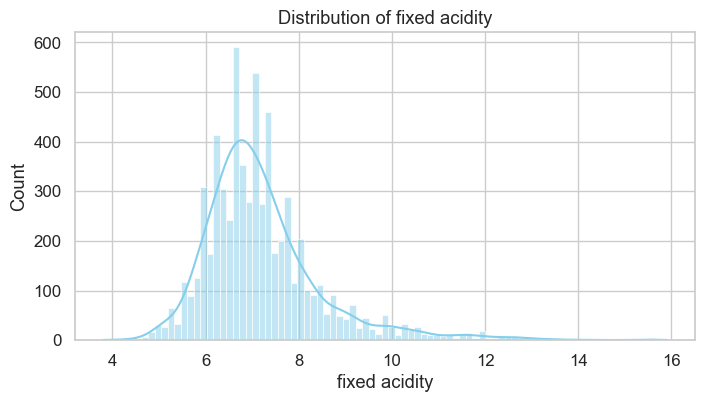

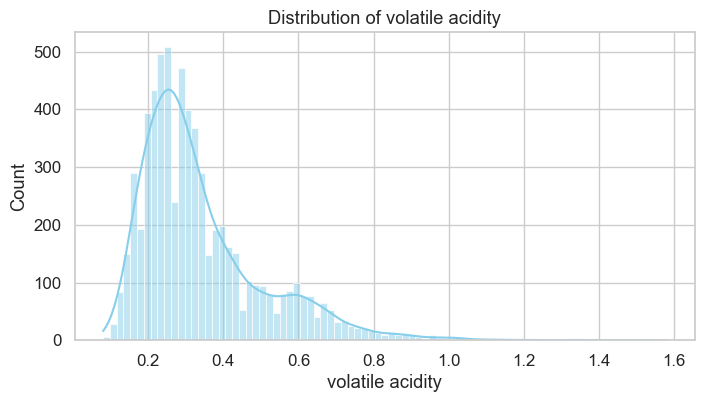

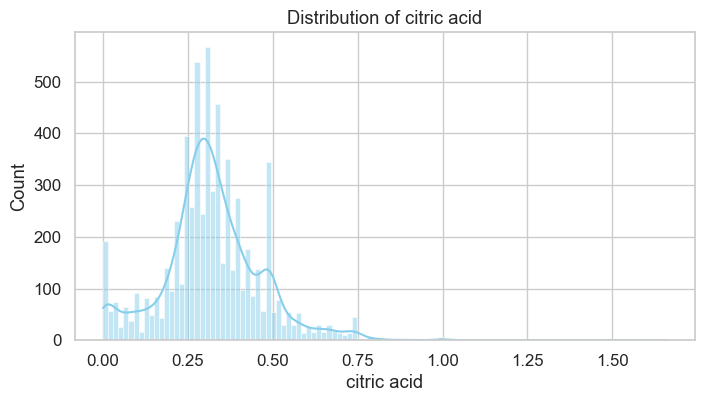

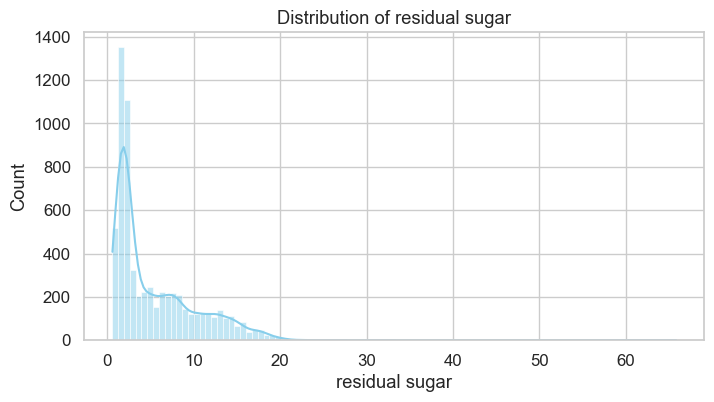

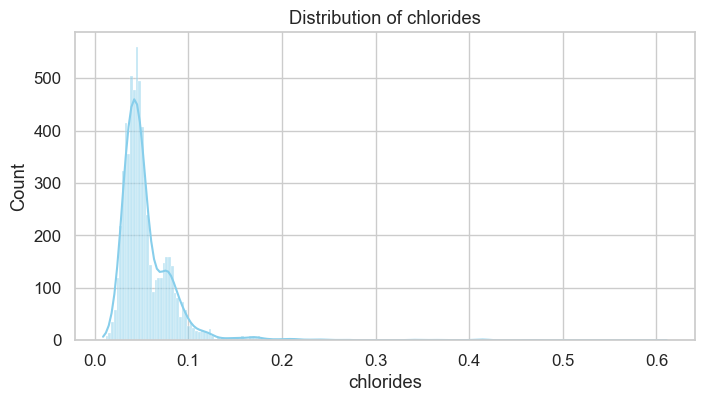

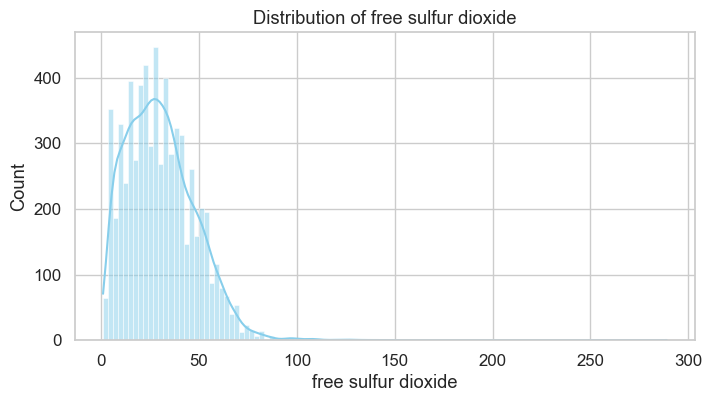

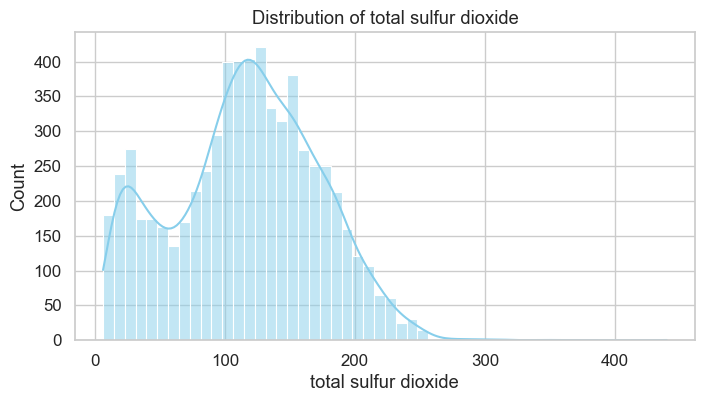

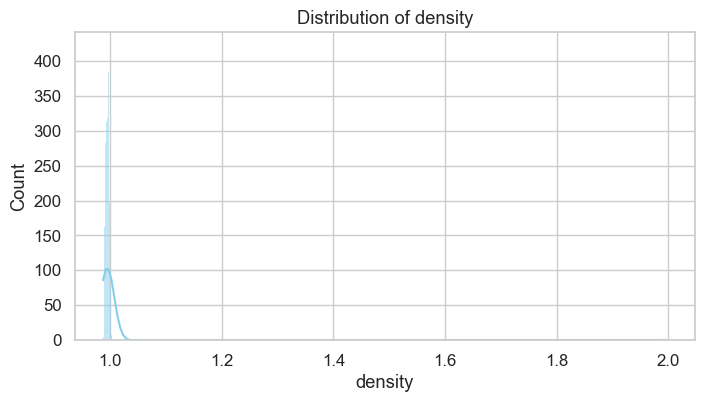

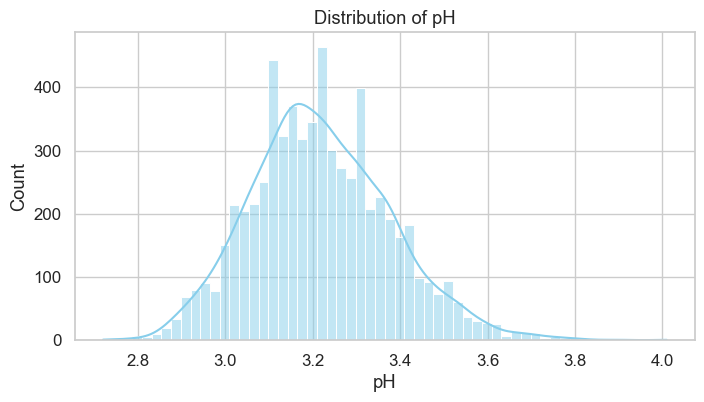

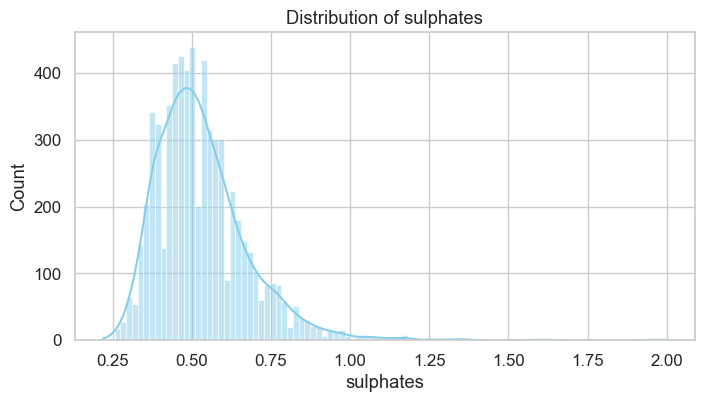

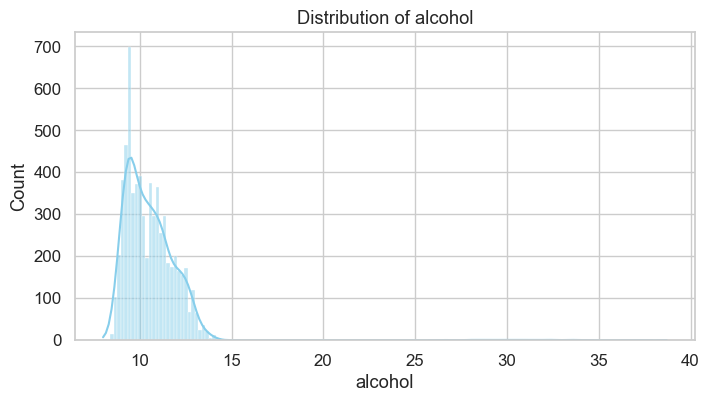

In [56]:
num_features = df.select_dtypes(include=['float64', 'int64']).columns.drop('quality')

for col in num_features:
    plt.figure(figsize=(8,4))
    sns.histplot(data=df, x=col, kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.show()


#### Boxplots to visualize outliers

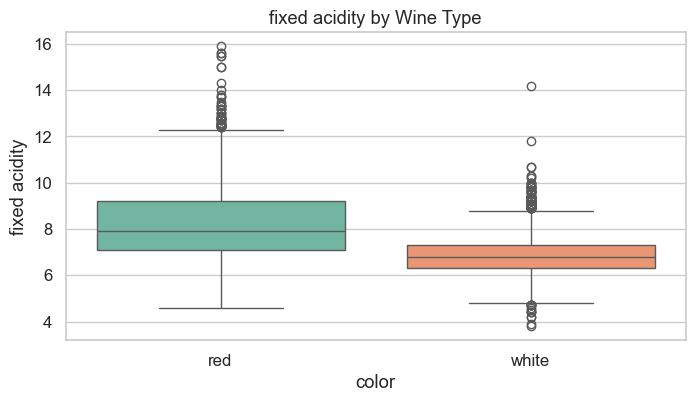

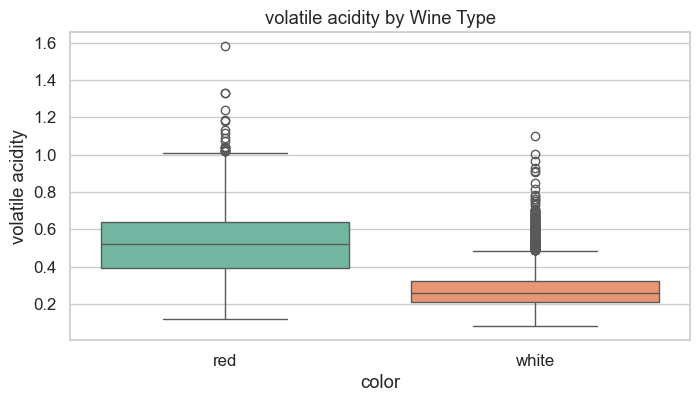

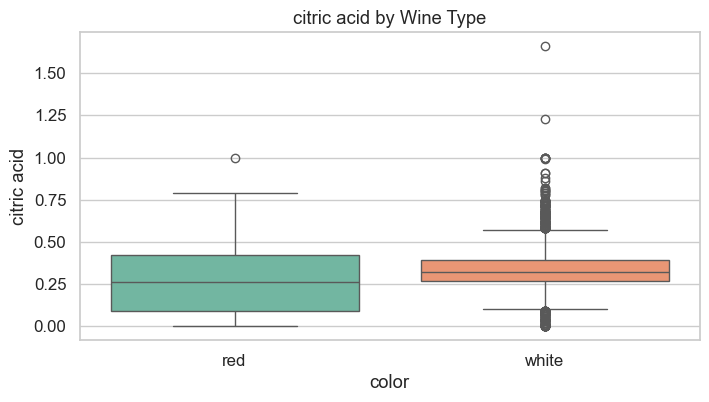

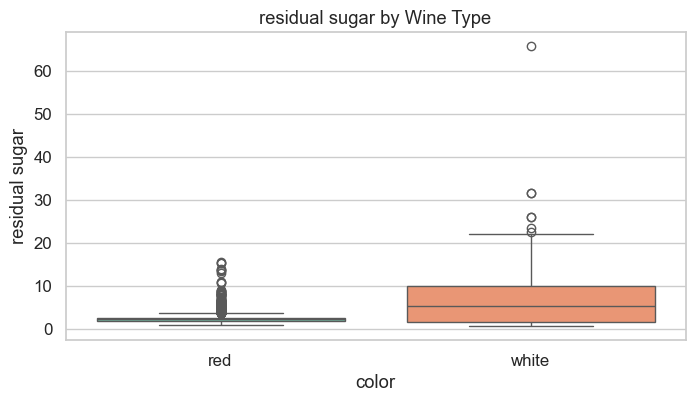

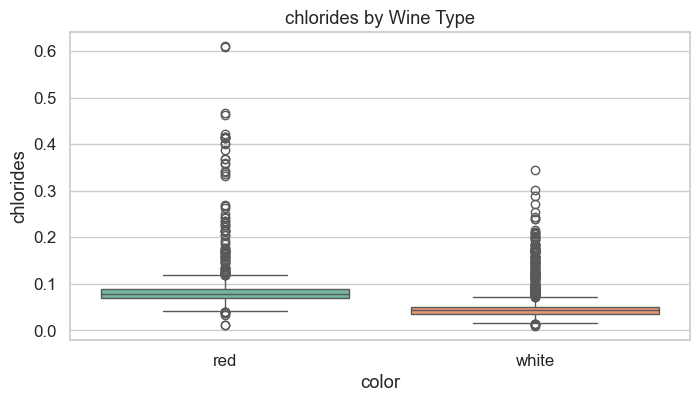

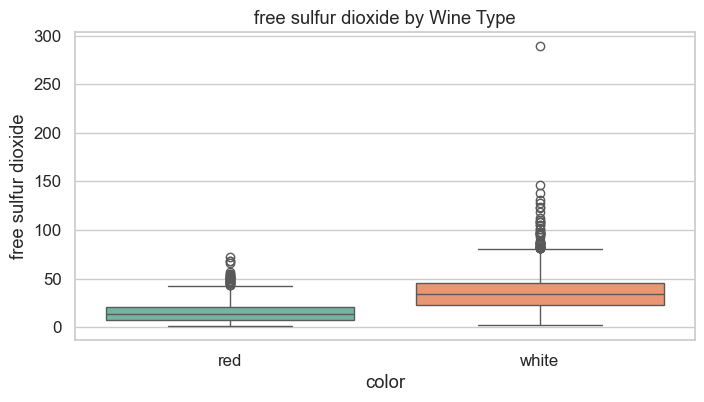

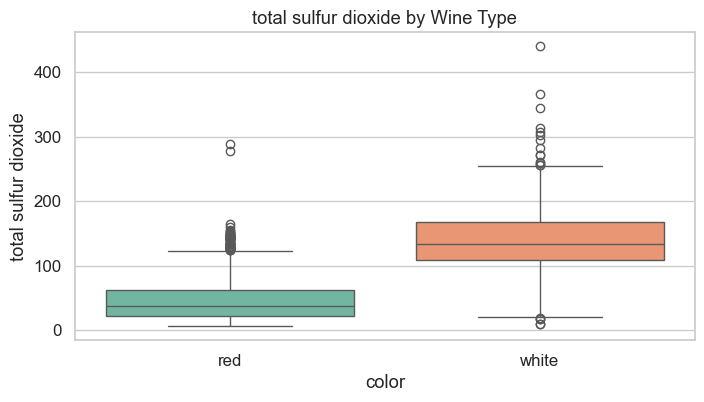

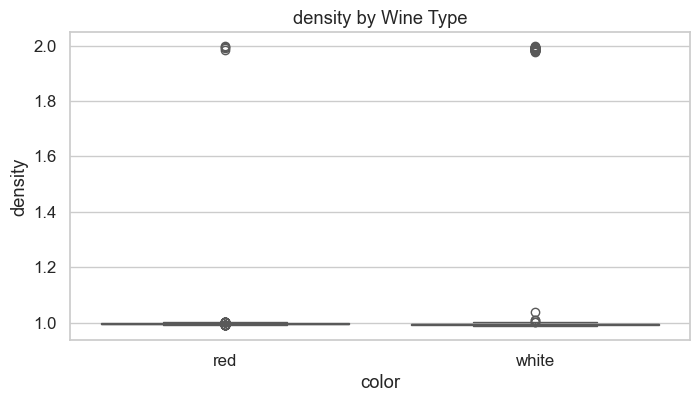

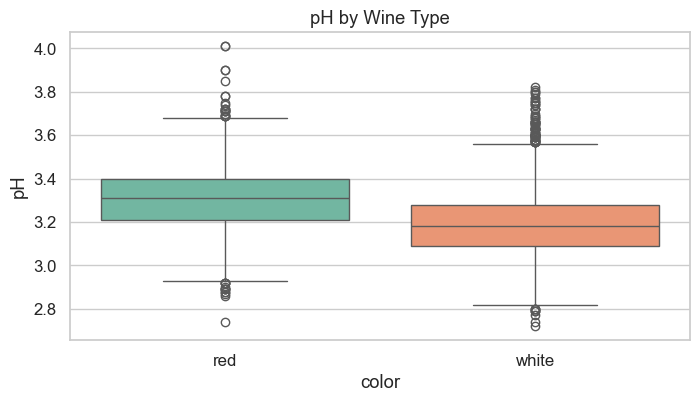

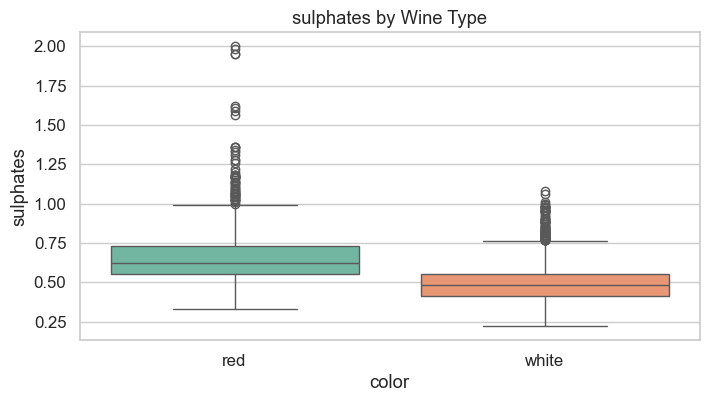

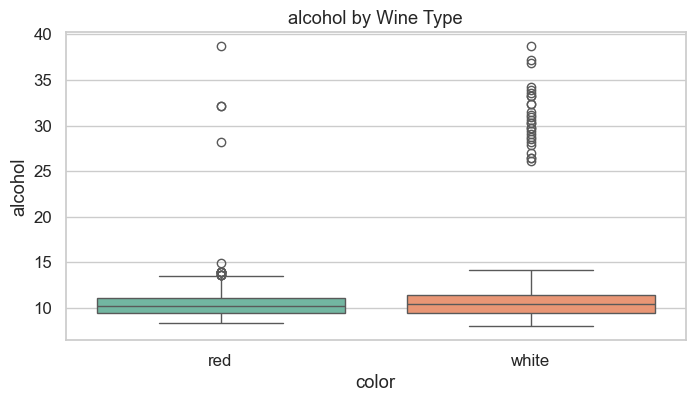

In [57]:
for col in num_features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='color', y=col,hue='color', data=df, palette='Set2', legend=False)
    plt.title(f'{col} by Wine Type')
    plt.show()


### Correlation Heatmap

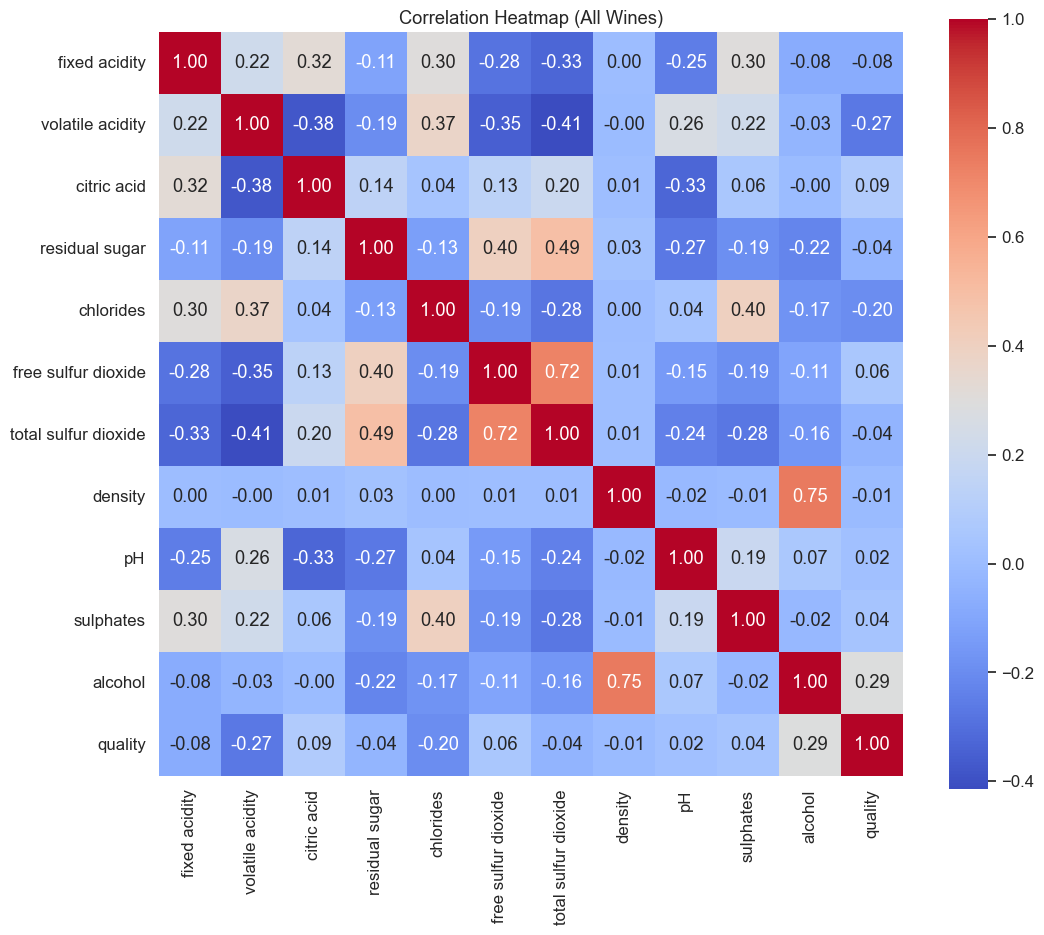

In [58]:
plt.figure(figsize=(12,10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Correlation Heatmap (All Wines)")
plt.show()

### Relationship Between Features and Quality

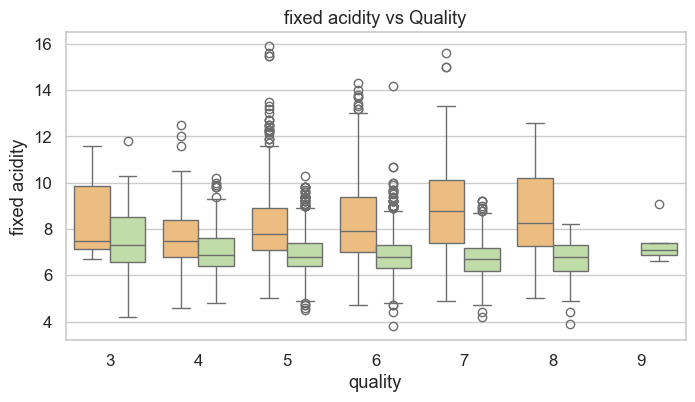

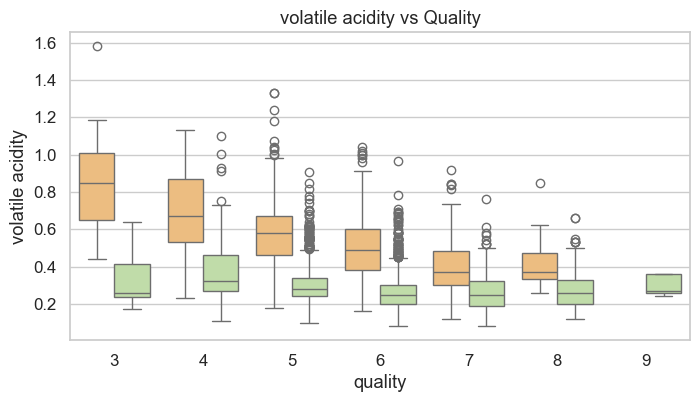

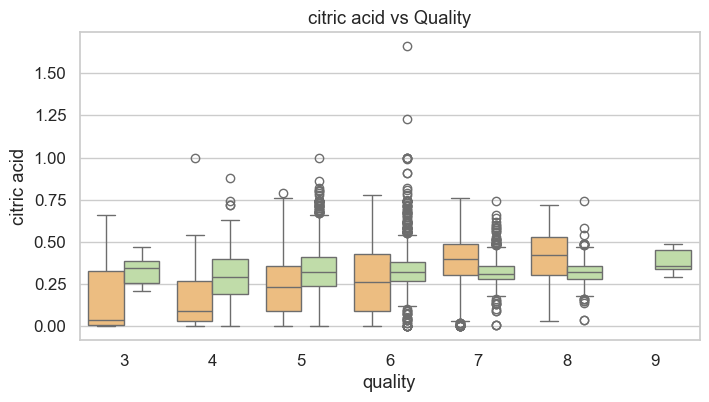

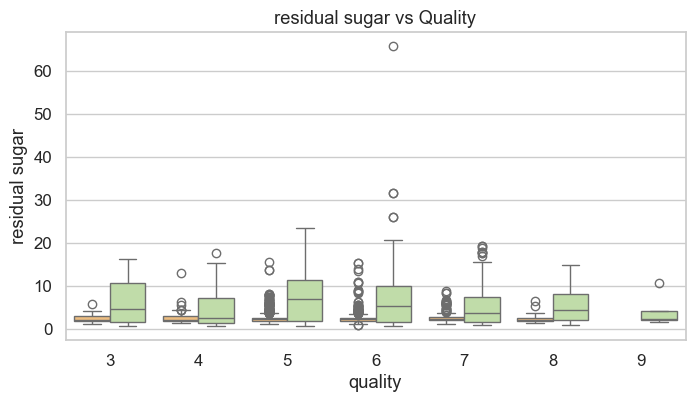

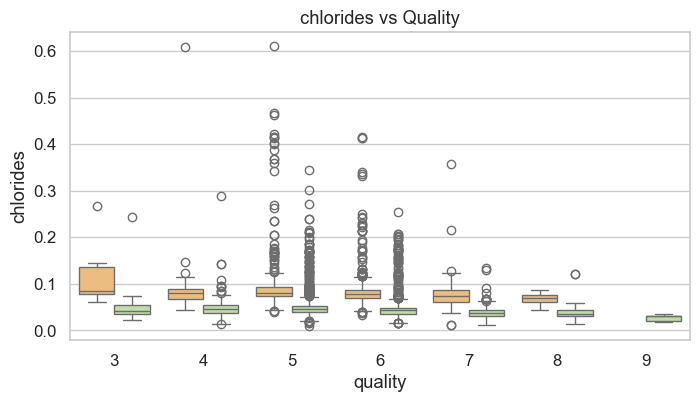

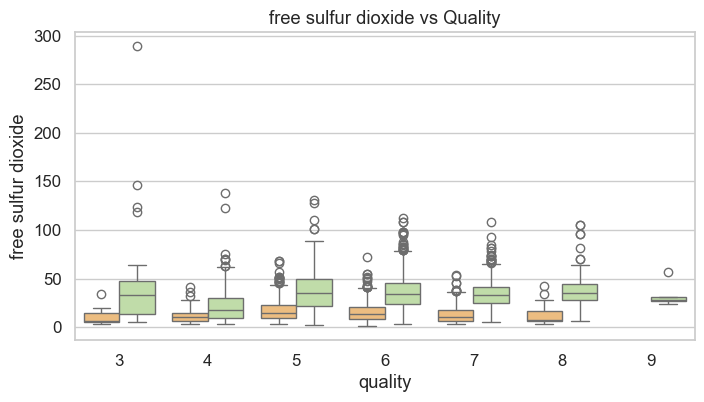

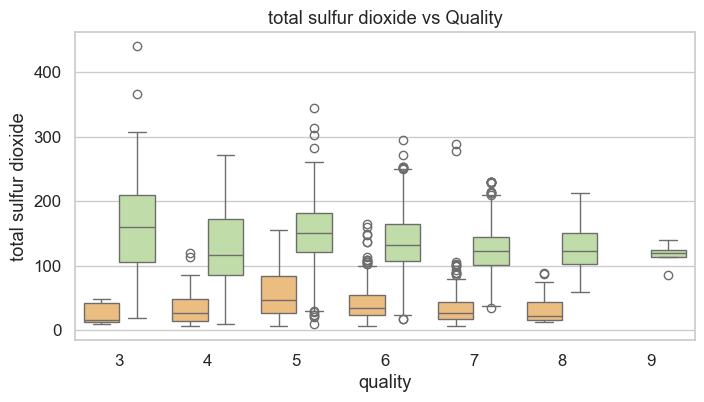

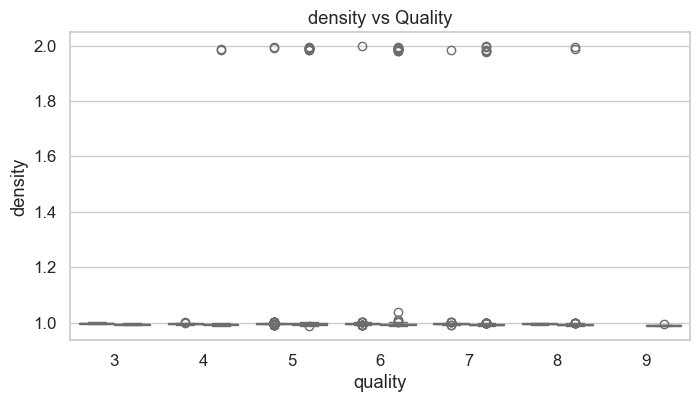

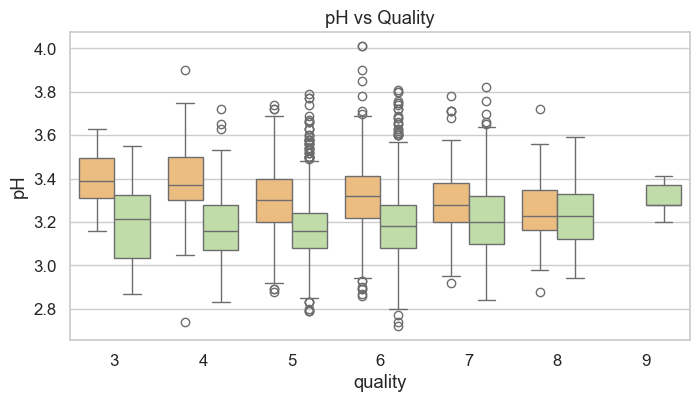

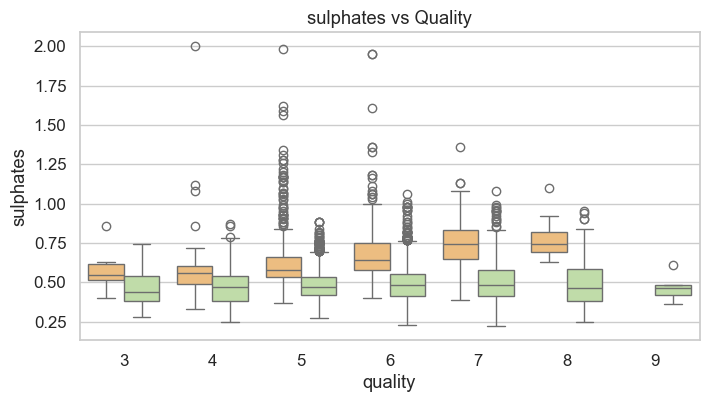

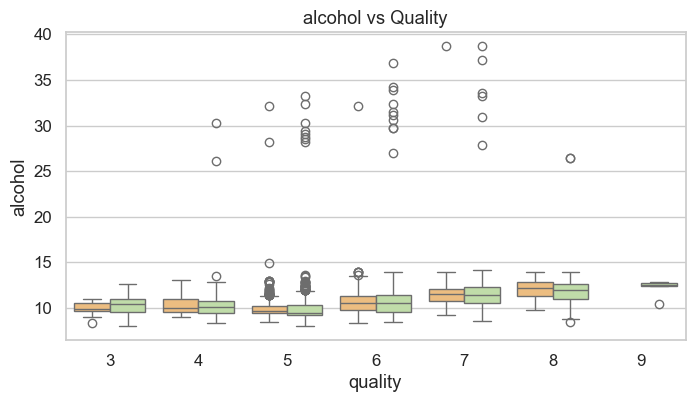

In [59]:
for col in num_features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='quality', y=col,hue='color', data=df, palette='Spectral', legend=False)
    plt.title(f'{col} vs Quality')
    plt.show()

### Key Correlations with Quality

In [60]:
corr_with_quality = corr['quality'].sort_values(ascending=False)
print("\n--- Correlation of Features with Quality ---")
print(corr_with_quality)


--- Correlation of Features with Quality ---
quality                 1.000000
alcohol                 0.287265
citric acid             0.085532
free sulfur dioxide     0.055463
sulphates               0.039735
pH                      0.019506
density                -0.006110
residual sugar         -0.037848
total sulfur dioxide   -0.041385
fixed acidity          -0.076743
chlorides              -0.198754
volatile acidity       -0.265699
Name: quality, dtype: float64


### Bivariate Relationships (Scatter Plots)

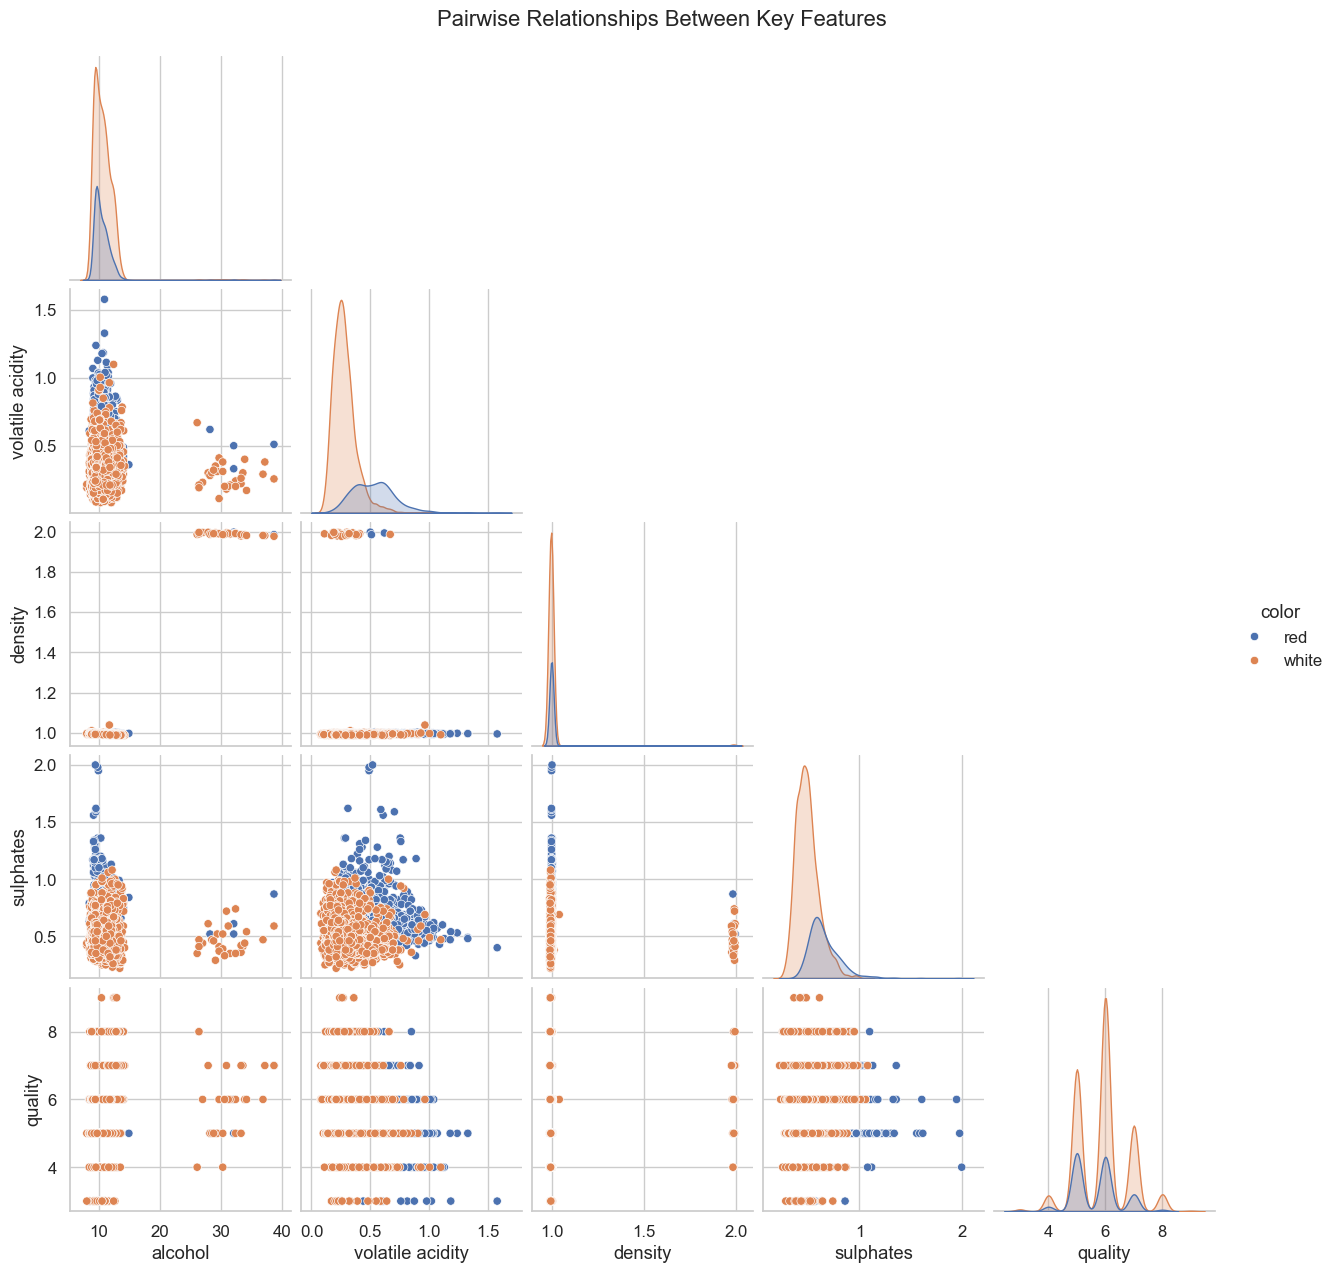

In [61]:
sns.pairplot(df[['alcohol', 'volatile acidity', 'density', 'sulphates', 'quality', 'color']], 
             hue='color', diag_kind='kde', corner=True)
plt.suptitle('Pairwise Relationships Between Key Features', y=1.02)
plt.show()

### Comparing Red vs White Wines

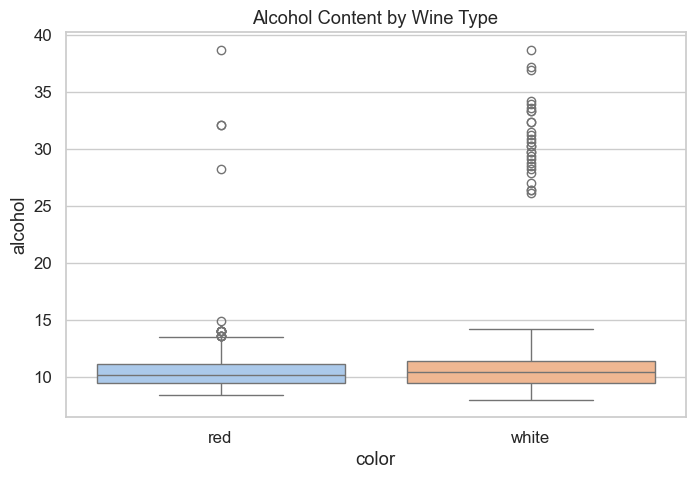

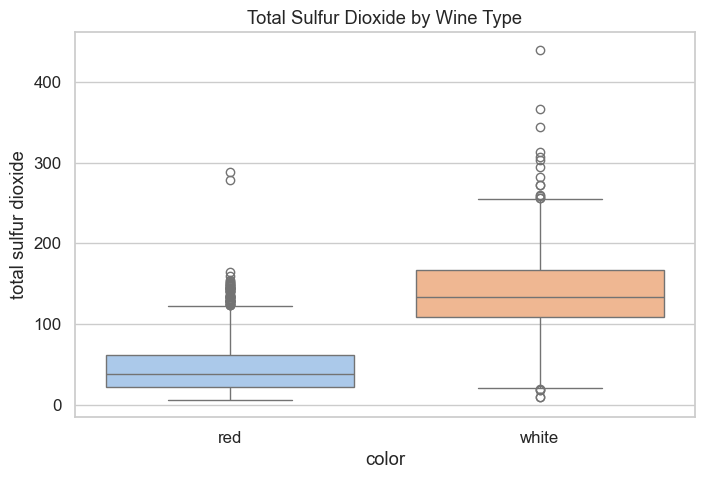

In [62]:
plt.figure(figsize=(8,5))
sns.boxplot(x='color', y='alcohol',hue='color', data=df, palette='pastel', legend=False)
plt.title('Alcohol Content by Wine Type')
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='color', y='total sulfur dioxide',hue='color', data=df, palette='pastel', legend=False)
plt.title('Total Sulfur Dioxide by Wine Type')
plt.show()

### Statistical Test Example: Red vs White Alcohol

In [63]:
red_alcohol = df[df['color']=='red']['alcohol']
white_alcohol = df[df['color']=='white']['alcohol']
t_stat, p_val = stats.ttest_ind(red_alcohol, white_alcohol, equal_var=False)
print(f"\nT-test: Alcohol (Red vs White) | t={t_stat:.3f}, p={p_val:.5f}")


T-test: Alcohol (Red vs White) | t=-3.215, p=0.00132


### Outlier Detection (Z-score method)

In [64]:
z_scores = np.abs(stats.zscore(df[num_features]))
outliers = (z_scores > 3).sum()
outlier_percent = 100 * (z_scores > 3).values.sum() / z_scores.size
print(f"\nEstimated outliers per feature:\n{outliers}")
print(f"Total outlier cells percentage: {outlier_percent:.2f}%")


Estimated outliers per feature:
fixed acidity           128
volatile acidity         95
citric acid              28
residual sugar            0
chlorides                 0
free sulfur dioxide      36
total sulfur dioxide      8
density                  32
pH                       33
sulphates                 0
alcohol                  32
dtype: int64
Total outlier cells percentage: 0.55%


### PCA for Dimensionality Reduction

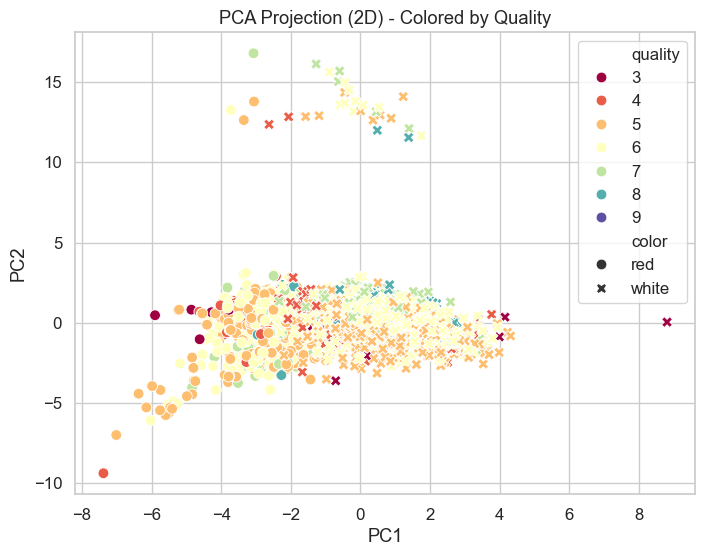


Explained Variance by PC1 & PC2: 44.23%


In [65]:
features = df[num_features]

# Because of the missing values
features_imputed = features.fillna(features.median())
X_scaled = StandardScaler().fit_transform(features_imputed)

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
df_pca['quality'] = df['quality']
df_pca['color'] = df['color']

plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='quality', style='color', data=df_pca, palette='Spectral', s=60)
plt.title('PCA Projection (2D) - Colored by Quality')
plt.show()

print(f"\nExplained Variance by PC1 & PC2: {pca.explained_variance_ratio_.sum():.2%}")

### Summary of Findings
1. No missing values in the dataset.
2. Quality scores are mostly between 5–7, showing moderate wine quality overall.
3. Alcohol and sulphates are positively correlated with quality.
4. Volatile acidity and density are negatively correlated with quality.
5. White wines generally have higher total sulfur dioxide and residual sugar.
6. Red wines tend to have higher volatile acidity and slightly lower alcohol.
7. PCA reveals a clear partial separation between red and white wines, indicating chemical distinctiveness.
8. Outliers exist mainly in sulfur dioxide and residual sugar — likely natural, not erroneous.

# 2. Data Preparation

In this section, we prepare the Wine Quality dataset for machine learning.  
The goal is to clean, transform, and encode the data so that it can be used to train predictive models effectively.

### Handle Missing Values

In [66]:
print("\n🔧 Handling missing values...")
print("Before:", df.isnull().sum().sum(), "missing values total")

df[num_features] = df[num_features].fillna(df[num_features].median())

print("After:", df.isnull().sum().sum(), "missing values total")


🔧 Handling missing values...
Before: 195 missing values total
After: 0 missing values total


### Handle Outliers

In [67]:
for col in num_features:
    lower, upper = df[col].quantile([0.01, 0.99])
    df[col] = np.clip(df[col], lower, upper)

print("\n✅ Outliers capped at 1st and 99th percentiles.")


✅ Outliers capped at 1st and 99th percentiles.


### Feature Engineering

In [68]:
df["sulfur_ratio"] = df["free sulfur dioxide"] / (df["total sulfur dioxide"] + 1e-6)
df["sulfur_ratio"] = df["sulfur_ratio"].replace([np.inf, -np.inf], np.nan).fillna(df["sulfur_ratio"].median())

### Define Target Variable (classification: good vs not good)

In [69]:
df["quality_label"] = (df["quality"] >= 7).astype(int)
y = df["quality_label"]
X = df.drop(columns=["quality", "quality_label"])


### Train-Test Split

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining size: {X_train.shape}, Test size: {X_test.shape}")


Training size: (5197, 13), Test size: (1300, 13)


### Identify Column Types

In [71]:
num_features = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
cat_features = ["color"]

### Preprocessing Pipelines

In [72]:
log_transformer = FunctionTransformer(np.log1p, validate=False)

numeric_pipeline = Pipeline(steps=[
    ("log", log_transformer),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95))
])

categorical_pipeline = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_features),
        ("cat", categorical_pipeline, cat_features)
    ]
)

### Full Modeling Pipeline

In [73]:
model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced",
    max_depth=None
)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", model)
])